# New Section

In [4]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval
import numpy as np
import pandas as pd

In [5]:
arxiv_data = pd.read_csv("arxiv_data_210930-054931.csv")

In [7]:
arxiv_data.head()

,terms,titles,abstracts
0,['cs.LG'],Multi-Level Attention Pooling for Graph Neural...,Graph neural networks (GNNs) have been widely ...
1,"['cs.LG', 'cs.AI']",Decision Forests vs. Deep Networks: Conceptual...,Deep networks and decision forests (such as ra...
2,"['cs.LG', 'cs.CR', 'stat.ML']",Power up! Robust Graph Convolutional Network v...,Graph convolutional networks (GCNs) are powerf...
3,"['cs.LG', 'cs.CR']",Releasing Graph Neural Networks with Different...,With the increasing popularity of Graph Neural...
4,['cs.LG'],Recurrence-Aware Long-Term Cognitive Network f...,Machine learning solutions for pattern classif...


In [8]:
arxiv_data.shape

(56181, 3)

In [9]:
arxiv_data.isnull().sum()

,0
terms,0
titles,0
abstracts,0


In [10]:
arxiv_data.duplicated().sum()

15054

In [11]:
labels_column = arxiv_data['terms'].apply(literal_eval)
labels = labels_column.explode().unique()
print("labels :",labels)
print("lenght :",len(labels))

labels : ['cs.LG' 'cs.AI' 'cs.CR' ... 'D.1.3; G.4; I.2.8; I.2.11; I.5.3; J.3'
 '68T07, 68T45, 68T10, 68T50, 68U35' 'I.2.0; G.3']
lenght : 1177


In [13]:
arxiv_data = arxiv_data[~arxiv_data['titles'].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")
# There are some terms with occurrence as low as 1.
print(sum(arxiv_data['terms'].value_counts()==1))
# how many unique terms
print(arxiv_data['terms'].nunique())


There are 41105 rows in the deduplicated dataset.
2503
3401


In [21]:
arxiv_data_filtered = arxiv_data.groupby('terms').filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(38602, 3)

In [22]:
arxiv_data_filtered['terms'] = arxiv_data_filtered['terms'].apply(lambda x: literal_eval(x))
arxiv_data_filtered['terms'].values[:3]

array([list(['cs.LG']), list(['cs.LG', 'cs.AI']),
       list(['cs.LG', 'cs.CR', 'stat.ML'])], dtype=object)

**Train and Test Split**

In [23]:
test_split = 0.1

# Initial train and test split.
# The stratify parameter ensures that the splitting is done in a way that preserves the same distribution of labels (terms) in both the training and test sets.
train_df, test_df = train_test_split(arxiv_data_filtered,test_size=test_split,stratify=arxiv_data_filtered["terms"].values,)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 34741
Number of rows in validation set: 1930
Number of rows in test set: 1931


In [24]:
terms = tf.ragged.constant(train_df['terms'].values)
# This line creates a StringLookup layer in TensorFlow. The purpose of this layer is to map strings to integer indices and vice versa. The output_mode="multi_hot" indicates that the layer will output a multi-hot encoded representation of the input strings.
lookup = tf.keras.layers.StringLookup(output_mode='multi_hot')
# This step adapts the StringLookup layer to the unique values in the "terms" column, building the vocabulary.
lookup.adapt(terms)
# retrieve vocabulary
vocab = lookup.get_vocabulary()

print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.GR', 'cs.CR', 'math.OC', 'eess.SP', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'eess.SY', 'cs.MA', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'stat.AP', 'cs.CY', 'stat.ME', 'stat.TH', 'math.ST', 'eess.AS', 'cs.SD', 'cs.DS', 'q-bio.QM', 'q-bio.NC', 'stat.CO', 'cs.CG', 'cs.NI', 'cs.GT', 'math.NA', 'cs.SE', 'cs.NA', 'I.2.6', 'physics.chem-ph', 'cs.DB', 'physics.comp-ph', 'cond-mat.dis-nn', 'q-bio.BM', 'math.PR', 'cs.PL', 'cs.LO', '68T45', 'cs.AR', 'physics.data-an', 'quant-ph', 'I.2.10', 'cs.CE', 'cond-mat.stat-mech', 'q-fin.ST', 'math.DS', 'I.4.6', 'physics.ao-ph', 'cs.CC', '68T05', 'physics.soc-ph', 'physics.med-ph', 'cs.PF', 'q-bio.GN', 'econ.EM', 'cs.DM', 'I.4.8', 'astro-ph.IM', 'physics.flu-dyn', 'math.AT', 'hep-ex', 'I.4', '68U10', 'q-fin.TR', 'physics.geo-ph', 'cs.FL', 'I.5.4', 'I.2', 'cond-mat.mtrl-sci', 'I.4.9', '68T10', 'physics.optics', 'I.4; I.5', '68T07', 'q-fin.CP', 'math.AP', 'I.2.6; 

In [25]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['cs.CV', 'cs.GR', 'cs.LG']
Label-binarized representation: [[0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [26]:
max_seqlen = 150
#batch_size: Batch size. It specifies the number of samples to use in each iteration.
batch_size = 128
#padding_token: A token used for padding sequences.
padding_token = "<pad>"
#auto = tf.data.AUTOTUNE: auto is assigned the value tf.data.AUTOTUNE,
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    # creating sequences of labesls
    labels = tf.ragged.constant(dataframe["terms"].values)
    #This line uses the previously defined lookup layer to convert the ragged tensor of labels into a binarized representation. The resulting label_binarized is a NumPy array.
    label_binarized = lookup(labels).numpy()
    # creating sequences of text.
    dataset = tf.data.Dataset.from_tensor_slices((dataframe["abstracts"].values, label_binarized))
    # shuffling data basis on condition
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)


In [27]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [29]:
def invert_multi_hot(multi_hot_vector, class_names):
    """
    Converts a multi-hot encoded vector to a list of class labels.

    Args:
        multi_hot_vector (numpy array): The multi-hot encoded label.
        class_names (list): List of class names corresponding to the indices.

    Returns:
        list: List of class labels corresponding to the active indices in the multi-hot vector.
    """
    return [class_names[i] for i, val in enumerate(multi_hot_vector) if val == 1]

# Example list of class names (Replace this with the actual class names in your dataset)
class_names = ["class_1", "class_2", "class_3", "class_4", "class_5"]

# Fixing the original code
text_batch, label_batch = next(iter(train_dataset))
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0], class_names)}")
    print(" ")


Abstract: b"Throughout the past five years, the susceptibility of neural networks to\nminimal adversarial perturbations has moved from a peculiar phenomenon to a\ncore issue in Deep Learning. Despite much attention, however, progress towards\nmore robust models is significantly impaired by the difficulty of evaluating\nthe robustness of neural network models. Today's methods are either fast but\nbrittle (gradient-based attacks), or they are fairly reliable but slow (score-\nand decision-based attacks). We here develop a new set of gradient-based\nadversarial attacks which (a) are more reliable in the face of gradient-masking\nthan other gradient-based attacks, (b) perform better and are more query\nefficient than current state-of-the-art gradient-based attacks, (c) can be\nflexibly adapted to a wide range of adversarial criteria and (d) require\nvirtually no hyperparameter tuning. These findings are carefully validated\nacross a diverse set of six different models and hold for L0, L1, 

IndexError: list index out of range

In [30]:
vocabulary = set()
train_df["abstracts"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

159087


**Text Vectorization**

In [31]:
text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size,ngrams=2,output_mode="tf_idf")
# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

In [32]:
train_dataset = train_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
validation_dataset = validation_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
test_dataset = test_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

# Creating shallow_mlp_model (MLP) with dropout layers
model1 = keras.Sequential([
    # First hidden layer: 512 neurons, ReLU activation function, with dropout.
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),  # Adding dropout for regularization.

    # Second hidden layer: 256 neurons, ReLU activation function, with dropout.
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),  # Adding dropout for regularization.

    # Output layer: The number of neurons equals the vocabulary size (output vocabulary of the StringLookup layer), with a sigmoid activation function.
    layers.Dense(lookup.vocabulary_size(), activation='sigmoid')
])

# Compile the model
model1.compile(loss="binary_crossentropy", optimizer='adam', metrics=['binary_accuracy'])

# Add early stopping
# Number of epochs with no improvement after which training will be stopped.
# Restore weights from the epoch with the best value of the monitored quantity.
early_stopping = EarlyStopping(patience=5,restore_best_weights=True)

# Train the model
# Add early stopping callback.verbose=1
history = model1.fit(train_dataset,validation_data=validation_dataset,epochs=20,callbacks=[early_stopping])

Epoch 1/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 686s 2s/step - binary_accuracy: 0.9489 - loss: 0.1214 - val_binary_accuracy: 0.9946 - val_loss: 0.0182
Epoch 2/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 671s 2s/step - binary_accuracy: 0.9947 - loss: 0.0188 - val_binary_accuracy: 0.9947 - val_loss: 0.0177
Epoch 3/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 679s 2s/step - binary_accuracy: 0.9957 - loss: 0.0142 - val_binary_accuracy: 0.9948 - val_loss: 0.0177
Epoch 4/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 666s 2s/step - binary_accuracy: 0.9965 - loss: 0.0117 - val_binary_accuracy: 0.9947 - val_loss: 0.0185
Epoch 5/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 674s 2s/step - binary_accuracy: 0.9970 - loss: 0.0099 - val_binary_accuracy: 0.9947 - val_loss: 0.0193
Epoch 6/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 657s 2s/step - binary_accuracy: 0.9974 - loss: 0.0086 - val_binary_accuracy: 0.9948 - val_loss: 0.0193
Epoch 7/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 686s 2s/step - binary_accuracy: 0.9977 - loss: 0.0078 - val_binary_accuracy: 0.9947 - val_loss: 0.0200

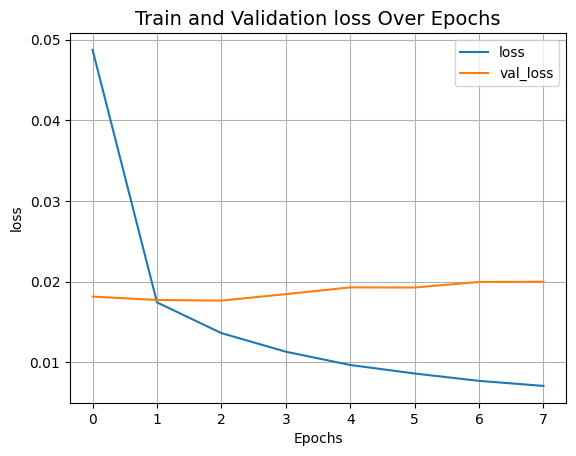

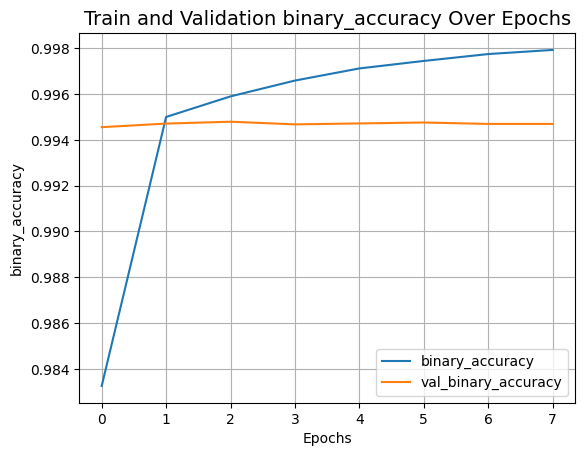

In [35]:
import matplotlib.pyplot as plt  # Add this line

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

# Call the function
plot_result("loss")
plot_result("binary_accuracy")


**Model Evaluation**

In [36]:
_, binary_acc1 = model1.evaluate(test_dataset)
_, binary_acc2 = model1.evaluate(validation_dataset)

print(f"Categorical accuracy on the test set: {round(binary_acc1 * 100, 2)}%.")
print(f"Categorical accuracy on the validation set: {round(binary_acc2 * 100, 2)}%.")

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 489ms/step - binary_accuracy: 0.9944 - loss: 0.0191
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 587ms/step - binary_accuracy: 0.9947 - loss: 0.0176
Categorical accuracy on the test set: 99.45%.
Categorical accuracy on the validation set: 99.48%.


In [14]:
pip install -U -q sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.4 MB/s eta 0:00:00


In [15]:
from sentence_transformers import SentenceTransformer, util

# Load the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Check if 'titles' column exists
if 'titles' in arxiv_data.columns:
    # Extract the titles from the dataset
    sentences = arxiv_data['titles'].tolist()  # Convert to list to avoid indexing issues
    embeddings = model.encode(sentences)
else:
    raise KeyError("Column 'titles' not found in arxiv_data. Check the dataset structure.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [16]:
embeddings

array([[ 0.06643405, -0.04954598,  0.06388085, ...,  0.00106302,
        -0.12156379, -0.06962775],
       [ 0.09212255, -0.07606938,  0.06572867, ..., -0.08565167,
        -0.09266547,  0.00725293],
       [-0.08162681,  0.02428931,  0.01888746, ...,  0.0080616 ,
        -0.0512953 , -0.05873995],
       ...,
       [ 0.01227978, -0.08568833, -0.02782771, ..., -0.05257976,
        -0.10806683,  0.07843316],
       [-0.07258201, -0.12690923, -0.00535554, ...,  0.03597707,
        -0.03986147, -0.05971023],
       [ 0.00768871, -0.10124183,  0.08909854, ..., -0.08199863,
        -0.05649742,  0.09007058]], dtype=float32)

**Print Embeddings**

In [17]:
# import pickle

# # Load sentences and embeddings from saved files
# try:
#     with open('models/sentences.pkl', 'rb') as f:
#         sentences = pickle.load(f)

#     with open('models/embeddings.pkl', 'rb') as f:
#         embeddings = pickle.load(f)

#     # Ensure embeddings and sentences have the same length
#     if len(sentences) != len(embeddings):
#         raise ValueError("Mismatch between number of sentences and embeddings")

#     c = 0

#     for sentence, embedding in zip(sentences, embeddings):
#         print("Sentence:", sentence)
#         print("Embedding length:", len(embedding))  # list of floats
#         print("")
#         # Breaks out of the loop after printing information for the first 5 sentences.
#         if c >= 5:
#             break
#         c += 1

# except FileNotFoundError as e:
#     print(f"Error: {e}. Make sure the required pickle files exist in the 'models' directory.")
# except Exception as e:
#     print(f"An error occurred: {e}")

c = 0
#This loop iterates over pairs of sentences and their corresponding embeddings.
#zip is used to iterate over both lists simultaneously.
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding length:", len(embedding)) # list of floats
    print("")
    # Breaks out of the loop after printing information for the first 5 sentences.
    if c >=5:
        break
    c +=1


Sentence: Multi-Level Attention Pooling for Graph Neural Networks: Unifying Graph Representations with Multiple Localities
Embedding length: 384

Sentence: Decision Forests vs. Deep Networks: Conceptual Similarities and Empirical Differences at Small Sample Sizes
Embedding length: 384

Sentence: Power up! Robust Graph Convolutional Network via Graph Powering
Embedding length: 384

Sentence: Releasing Graph Neural Networks with Differential Privacy Guarantees
Embedding length: 384

Sentence: Recurrence-Aware Long-Term Cognitive Network for Explainable Pattern Classification
Embedding length: 384

Sentence: Lifelong Graph Learning
Embedding length: 384



**Save Files**

In [18]:
import pickle
# Saving sentences and corresponding embeddings
with open('embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

with open('sentences.pkl', 'wb') as f:
    pickle.dump(sentences, f)

with open('rec_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [19]:
import torch

def recommendation(input_paper):
    # Calculate cosine similarity scores between the embeddings of input_paper and all papers in the dataset.
    cosine_scores = util.cos_sim(embeddings, rec_model.encode(input_paper))

    # Get the indices of the top-k most similar papers based on cosine similarity.
    top_similar_papers = torch.topk(cosine_scores, dim=0, k=5, sorted=True)

    # Retrieve the titles of the top similar papers.
    papers_list = []
    for i in top_similar_papers.indices:
        papers_list.append(sentences[i.item()])

    return papers_list

In [20]:
import torch
from sentence_transformers import SentenceTransformer, util

# Load the model
rec_model = SentenceTransformer('all-MiniLM-L6-v2')

# Check if embeddings and sentences exist
if 'embeddings' not in globals() or 'sentences' not in globals():
    raise ValueError("Error: Missing embeddings or sentences. Ensure they are properly loaded.")

def recommendation(input_paper):
    """Finds the top 5 most similar papers based on cosine similarity."""
    if not input_paper.strip():  # Prevents empty input
        print("Error: Paper title cannot be empty.")
        return []

    # Encode input paper
    input_embedding = rec_model.encode([input_paper])  # Ensure list format

    # Compute cosine similarity
    cosine_scores = util.cos_sim(embeddings, input_embedding)

    # Get top 5 similar papers
    top_similar_papers = torch.topk(cosine_scores.squeeze(), k=5)

    return [sentences[i.item()] for i in top_similar_papers.indices]

# Ensure user input is handled safely
try:
    input_paper = input("Enter the title of any paper you like: ").strip()

    if input_paper:  # Only proceed if input is not empty
        recommend_papers = recommendation(input_paper)

        print("\nWe recommend reading these papers:")
        print("=============================================")
        for paper in recommend_papers:
            print(paper)
    else:
        print("Error: Paper title cannot be empty. Please provide a valid title.")

except KeyboardInterrupt:
    print("\nProcess interrupted by user.")
except Exception as e:
    print(f"An error occurred: {e}")


Enter the title of any paper you like: Attention is All you Need

We recommend reading these papers:
Attention that does not Explain Away
Area Attention
Pay Attention when Required
Long Short-Term Attention
Attention as Activation


In [ ]:
import sentence_transformers
import tensorflow
import torch
print(torch.__version__)
print(sentence_transformers.__version__)
print(tensorflow.__version__)

2.5.1+cu124
3.4.1
2.18.0


In [ ]:
input_paper = input("Enter the title of any paper you like")
recommend_papers = recommendation(input_paper)


print("We recommend to read this paper............")
print("=============================================")
for paper in recommend_papers:
    print(paper)

Enter the title of any paper you likePre-training of Deep Bidirectional Transformers for Language Understanding
We recommend to read this paper............
Transformers are powerful for NLP tasks.
Sentence embeddings capture semantic meaning.
Deep learning models are data-hungry.
Machine learning is amazing!
AI is revolutionizing the world.
